# NST distribution evolution 1
This utilizes an example to highlight the change in the distribution.

In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
sys.path.insert(1, "./utils/")
import HH, Stimuli
from neuron import h
h.load_file("stdrun.hoc")
from neuron.units import mV, ms
import time

In [2]:
data_dir = './data/nst_distribution_evolution/'
figures_dir = './figures/'

## Load Stimuli

In [3]:
stimuli_files = os.listdir(f'{data_dir}stimuli/')
stimuli_ids = [int(f.split('_')[1].strip('.json')) for f in stimuli_files]

## Load Histories 

In [4]:
histories_sets = {
    'base': np.load(f'{data_dir}histories_base.npy'),
    'lw': np.load(f'{data_dir}histories_lw.npy'),
    'lt': np.load(f'{data_dir}histories_lt.npy'),
    'lwlt': np.load(f'{data_dir}histories_lwlt.npy'),
    'burst': np.load(f'{data_dir}histories_burst.npy')
}

## Load Data

In [5]:
results_files = os.listdir(f'{data_dir}results/')

results_stimuli_ids = [int(f.split('_')[1]) for f in results_files]

In [6]:
stim_scaffold = {
    'base': {
        'ex': Stimuli.PoissonStim(
            'ex_base', 'ex_base',
            interval=5,
            rev_potential=0,
            weight=0.0002,
            tau=2,
            seed='na'
        ),
        'in': Stimuli.PoissonStim(
            'in_base', 'in_base',
            interval=15,
            rev_potential=-80,
            weight=0.0005,
            tau=6,
            seed='na'
        )
    },
    'lw': {
        'ex': Stimuli.PoissonStim(
            'ex_lw', 'ex_lw',
            interval=5,
            rev_potential=0,
            weight=0.00015,
            tau=2,
            seed='na'
        ),
        'in': Stimuli.PoissonStim(
            'in_lw', 'in_lw',
            interval=15,
            rev_potential=-80,
            weight=0.0002,
            tau=6,
            seed='na'
        )
    },
    'lt': {
        'ex': Stimuli.PoissonStim(
            'ex_lt', 'ex_lt',
            interval=5,
            rev_potential=0,
            weight=0.0002,
            tau=10,
            seed='na'
        ),
        'in': Stimuli.PoissonStim(
            'in_lt', 'in_lt',
            interval=15,
            rev_potential=-80,
            weight=0.0005,
            tau=40,
            seed='na'
        )
    },
    'lwlt': {
        'ex': Stimuli.PoissonStim(
            'ex_lwlt', 'ex_lwlt',
            interval=5,
            rev_potential=0,
            weight=0.00015,
            tau=10,
            seed='na'
        ),
        'in': Stimuli.PoissonStim(
            'in_lwlt', 'in_lwlt',
            interval=15,
            rev_potential=-80,
            weight=0.0002,
            tau=40,
            seed='na'
        )
    },
    'burst': {
        'ex': Stimuli.PoissonStim(
            'ex_burst', 'ex_burst',
            interval=5,
            rev_potential=0,
            weight=0.0001,
            tau=40,
            seed='na'
        ),
        'in': Stimuli.PoissonStim(
            'in_burst', 'in_burst',
            interval=15,
            rev_potential=-80,
            weight=0.0005,
            tau=20,
            seed='na'
        )
    }
}

## Example

In [7]:
ns = [n for n in range(3, 21)]
num_histories = 1000

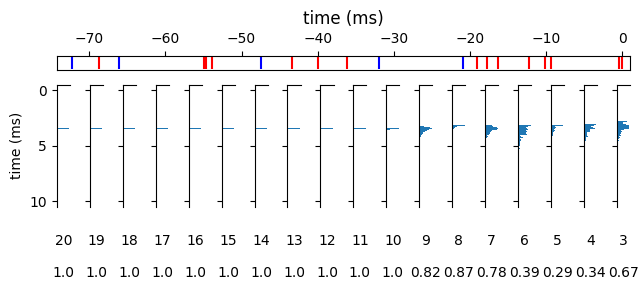

In [8]:
# hyperparameters
    # 1 - 3 - base: deterministic no spike at 12
    # 1 - 5 - base: deterministic spike at 10
stimuli_id = stimuli_ids[1]
stimuli_ind = 5
stim_type = 'base'

# load stimuli
with open(f'{data_dir}stimuli/stimuli_{stimuli_id}.json', 'r') as fin:
    stim_pattern = json.load(fin)[str(stimuli_ind)]
    
# load results
with open(f'{data_dir}results/{stim_type}_{stimuli_id}_{stimuli_ind}.json', 'r') as fin:
    results = json.load(fin)

# set up plot
hist_axes = [str(ind) for ind in ns]
step = 0.1
bins = np.arange(0, 10+step, step)

hist_axes.reverse()

max_time = max([t for event_type, t in stim_pattern])

gs_kw = dict( height_ratios=[.1, .9])
fig, axd = plt.subplot_mosaic(
    [['raster']*len(ns), hist_axes],
    gridspec_kw=gs_kw, figsize=(6.5, 3),
    )

# raster
# recenter input times
axd['raster'].vlines([t - max_time for event_type, t in stim_pattern if event_type == 'e'], 0, 1, colors='red')
axd['raster'].vlines([t - max_time for event_type, t in stim_pattern if event_type == 'i'], 0, 1, colors='blue')

axd['raster'].xaxis.tick_top()
axd['raster'].set_yticks([])
axd['raster'].set_xlim(- max_time -2, 1)
axd['raster'].set_title('time (ms)')

# histograms
for n in ns:
    axd[str(n)].hist(results[str(n)], bins=bins, orientation="horizontal")
    spike_freq = round(np.sum(~np.isnan(results[str(n)])) / len(results[str(n)]) , 2)
    axd[str(n)].set_xlabel('\n'+str(n)+'\n\n'+str(spike_freq))
    # aesthetics
    axd[str(n)].spines['bottom'].set_visible(False)
    axd[str(n)].spines['right'].set_visible(False)
    axd[str(n)].invert_yaxis()
    axd[str(n)].set_xticks([])
    if n != max(ns):
        axd[str(n)].set_yticklabels([])
    else:
        axd[str(n)].set_ylabel('time (ms)')

fig.tight_layout()
plt.show()

In [9]:
results = {n:[] for n in ns}
vm_traces = {n:{'spike':[], 'no_spike':[]} for n in ns}
t_traces = {n:None for n in ns}
print('_'*len(ns))
for n in ns:
    _stims = stim_pattern[-n:]

    # run a bunch of cells in parallel
    stim_min = min([t for stim_type, t in _stims])

    _e_times = [t - stim_min for stim_type, t in _stims if stim_type == 'e']
    _i_times = [t - stim_min for stim_type, t in _stims if stim_type == 'i']

    stim_duration = max(_e_times + _i_times) # total duration of the stimuli

    cells = {}
    fInitializeHandlers = []

    for history_ind in range(num_histories):
        history = histories_sets[stim_type][:, history_ind]
        cells[history_ind] = HH.HH()
        stim_scaffold[stim_type]['ex'].stim_times = _e_times
        stim_scaffold[stim_type]['in'].stim_times = _i_times
        cells[history_ind].add_custom_stimulus(stim_scaffold[stim_type]['ex'])
        cells[history_ind].add_custom_stimulus(stim_scaffold[stim_type]['in'])
        cells[history_ind].sim_init(
            v0 = history[0],
            m0 = history[1],
            h0 = history[2],
            n0 = history[3]
        )
        fInitializeHandlers.append(h.FInitializeHandler(cells[history_ind].do_sim_init))

    h.finitialize(-65)
    h.continuerun(stim_duration + 20 * ms)

    for history_ind in range(num_histories):
        nsts = [spike - stim_duration for spike in list(cells[history_ind].spike_times)]
        nsts = [nst for nst in nsts if nst > 0]        
        if len(nsts) < 1:
            results[n].append(np.nan)
            vm_traces[n]['no_spike'].append(cells[history_ind]._v)
        else:
            results[n].append(min(nsts))
            vm_traces[n]['spike'].append(cells[history_ind]._v)
        t_traces[n] = cells[history_ind]._t
    print(']',end='')

__________________
]]]]]]]]]]]]]]]]]]

In [10]:
def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

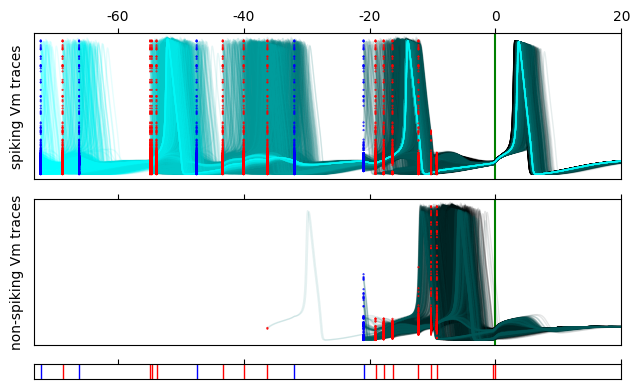

In [14]:
fig, axes = plt.subplots(
    3,1, figsize=(6.5,4), sharey=True, gridspec_kw={'height_ratios': [10,10,1]}, layout='tight'
)

# colors for the color gradient
color1 = "#00FFFF"
color2 = "#000000"
def stimtype2color(stim_type):
    if stim_type == 'e':
        return 'red'
    elif stim_type == 'i':
        return 'blue'
    else:
        print('color error')
        return 'ERROR'

t_inits_spike = []
v_inits_spike = []
c_inits_spike = []
t_inits_no_spike = []
v_inits_no_spike = []
c_inits_no_spike = []

for i in range(len(ns)):
    n = 20-i
    _stims = stim_pattern[-n:]
    _t = np.array(t_traces[n]) - (max(t_traces[n]) - 20)
    
    for vm_trace in vm_traces[n]['spike']:
        axes[0].plot(_t, vm_trace, alpha=0.1, 
                     zorder=n, color=get_color_gradient(color1, color2, len(ns))[i], linewidth=1)
        
        t_inits_spike.append(_t[0])
        v_inits_spike.append(vm_trace[0])
        c_inits_spike.append(stimtype2color(_stims[0][0]))
    for vm_trace in vm_traces[n]['no_spike']:
        axes[1].plot(_t, vm_trace, alpha=0.1, 
                     zorder=n, color=get_color_gradient(color1, color2, len(ns))[i], linewidth=1)
        t_inits_no_spike.append(_t[0])
        v_inits_no_spike.append(vm_trace[0])
        c_inits_no_spike.append(stimtype2color(_stims[0][0]))

# sim initializations
scatter = axes[0].scatter(t_inits_spike, v_inits_spike, c=c_inits_spike, s=0.2, zorder=100)
axes[1].scatter(t_inits_no_spike, v_inits_no_spike, c=c_inits_no_spike, s=0.2, zorder=100)

# t0 vlines
axes[0].vlines(0, -100, 100, color='green')
axes[1].vlines(0, -100, 100, color='green')

# stimuli rasters
red = axes[2].vlines(
    [t - max_time for event_type, t in stim_pattern if event_type == 'e'], -100, 100, colors='red', linewidths=1
)
blue = axes[2].vlines(
    [t - max_time for event_type, t in stim_pattern if event_type == 'i'], -100, 100, colors='blue', linewidths=1
)
axes[2].set_yticks([])

# general aesthetics
for ax in axes:
    ax.set_ylim(-80, 45)
    ax.set_xlim(-max(np.array(t_traces[20]))+20-1, 20)

axes[0].set_ylabel('spiking Vm traces')
axes[1].set_ylabel('non-spiking Vm traces')

x_ticks = np.arange(-60,21,20)
axes[0].set_xticks(x_ticks)
axes[0].set_xticklabels(x_ticks)
axes[0].xaxis.tick_top()
axes[1].xaxis.tick_top()
axes[2].xaxis.tick_top()
axes[1].set_xticklabels([])
axes[2].set_xticklabels([])
#axes[-1].set_xlabel('time (ms)', fontsize=14)
#axes[1].legend([red, blue], ['excitatory initializations','inhibitory initializations'], loc='upper right')
plt.savefig(f'{figures_dir}nst_dist_evolution_part1.png', format='png', dpi=300)
plt.show()

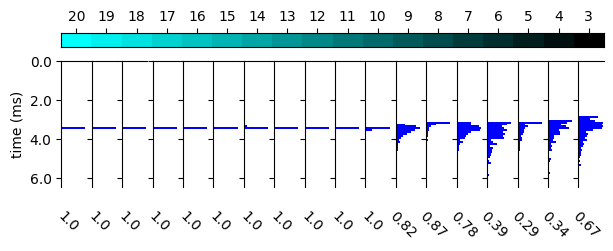

In [19]:
stimuli_id = stimuli_ids[1]
stimuli_ind = 5
stim_type = 'base'

# load stimuli
with open(f'{data_dir}stimuli/stimuli_{stimuli_id}.json', 'r') as fin:
    stim_pattern = json.load(fin)[str(stimuli_ind)]
    
# load results
with open(f'{data_dir}results/{stim_type}_{stimuli_id}_{stimuli_ind}.json', 'r') as fin:
    results = json.load(fin)

# set up plot
hist_axes = [str(ind) for ind in ns]
step = 0.1
bins = np.arange(0, 7+step, step)

hist_axes.reverse()

max_time = max([t for event_type, t in stim_pattern])

gs_kw = dict( height_ratios=[.1, .9])
fig, axd = plt.subplot_mosaic(
    [['raster']*len(ns), hist_axes],
    gridspec_kw=gs_kw, figsize=(7, 2),
    )

# raster
# recenter input times
for i in range(len(ns)):
    rect = patches.Rectangle((i, 1), 1, 1, linewidth=1, facecolor=get_color_gradient(color1, color2, len(ns))[i])
    axd['raster'].add_patch(rect)
axd['raster'].set_xlim(0, len(ns))
axd['raster'].set_ylim(1, 2)
axd['raster'].xaxis.tick_top()
axd['raster'].set_xticks(np.arange(.5,len(ns)+.5))
axd['raster'].set_xticklabels(np.arange(20,2, -1))
axd['raster'].set_yticks([])

# histograms
for n in ns:
    axd[str(n)].hist(results[str(n)], bins=bins, orientation="horizontal", color='b')
    spike_freq = round(np.sum(~np.isnan(results[str(n)])) / len(results[str(n)]) , 2)
    axd[str(n)].set_xlabel('\n'+str(spike_freq),rotation=315)
    # aesthetics
    axd[str(n)].set_ylim(0,6.5)
    axd[str(n)].spines['bottom'].set_visible(False)
    axd[str(n)].spines['right'].set_visible(False)
    axd[str(n)].invert_yaxis()
    axd[str(n)].set_xticks([])
    if n != max(ns):
        axd[str(n)].set_yticklabels([])
    else:
        ticks = np.arange(0,6.1,2)
        axd[str(n)].set_yticks(ticks)
        axd[str(n)].set_yticklabels(ticks)
        axd[str(n)].set_ylabel('time (ms)')
plt.savefig(f'{figures_dir}nst_dist_evolution_part2.png', format='png',dpi=300)
#fig.tight_layout()
plt.show()